# Basic MIMO Simulations
In this notebook, you will learn how to setup simulations of MIMO transmissions over
a flat-fading channel.

Here is a schematic diagram of the system model with all required components:

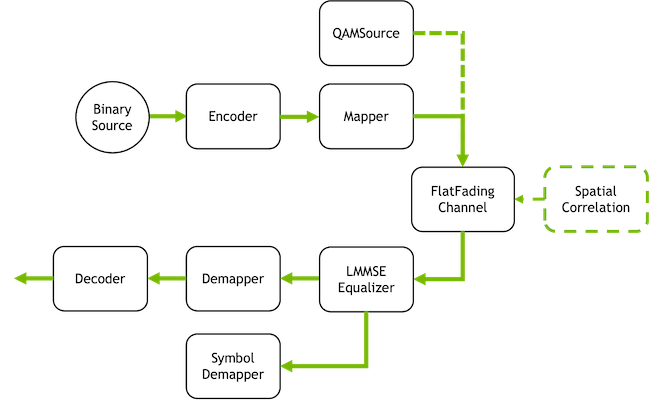

You will learn how to:

* Use the FastFadingChannel class
* Apply spatial antenna correlation
* Implement LMMSE detection with perfect channel knowledge
* Run BER/SER simulations

We will first walk through the configuration of all components of the system model, before building a general Keras model which will allow you to run efficiently simulations with different parameter settings.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simple uncoded transmission](#Simple-uncoded-transmission)
    * [Adding spatial correlation](#Adding-spatial-correlation)
* [Extension to channel coding](#Extension-to-channel-coding)
    * [BER simulations using a Keras model](#BER-simulations-using-a-Keras-model)

### GPU Configuration and Imports

In [1]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

## Simple uncoded transmission

We will consider point-to-point transmissions from a transmitter with `num_tx_ant` antennas to a receiver
with `num_rx_ant` antennas. The transmitter applies no precoding and sends independent data stream from each antenna.

Let us now generate a batch of random transmit vectors of random 16QAM symbols:

In [3]:
num_tx_ant = 4
num_rx_ant = 16
num_bits_per_symbol = 4
batch_size = 1024
qam_source = QAMSource(num_bits_per_symbol)
x = qam_source([batch_size, num_tx_ant])
print(x.shape)

(1024, 4)


Next, we will create an instance of the `FlatFadingChannel` class to simulate transmissions over
an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
As we will need knowledge of the channel realizations for detection, we activate the `return_channel` flag.

In [4]:
channel = FlatFadingChannel(num_tx_ant, num_rx_ant, add_awgn=True, return_channel=True)
no = 0.2 # Noise variance of the channel

# y and h are the channel output and channel realizations, respectively.
y, h = channel([x, no])
print(y.shape)
print(h.shape)

(1024, 16)
(1024, 16, 4)


Using the perfect channel knowledge, we can now implement an LMMSE equalizer to compute soft-symbols.
The noise covariance matrix in this example is just a scaled identity matrix which we need to provide to the
`lmmse_equalizer`.

In [5]:
s = tf.cast(no*tf.eye(num_rx_ant, num_rx_ant), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)

Let us know have a look at the transmitted and received constellations:

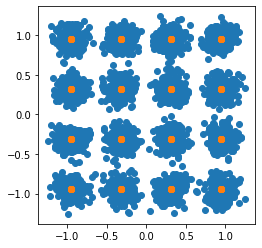

In [6]:
plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat), np.imag(x_hat));
plt.scatter(np.real(x), np.imag(x));

As expected, the soft symbols `x_hat` are scattered around the 16QAM constellation points.
The equalizer output `no_eff` provides an estimate of the effective noise variance for each soft-symbol.

In [7]:
print(no_eff.shape)

(1024, 4)


One can confirm that this estimate is correct by comparing the MSE between the transmitted and equalized symbols against the average estimated effective noise variance:

In [8]:
noise_var_eff = np.var(x-x_hat)
noise_var_est = np.mean(no_eff)
print(noise_var_eff)
print(noise_var_est)

0.016707737
0.016417634


The last step is to make hard decisions on the symbols and compute the SER:

In [9]:
symbol_demapper = SymbolDemapper("qam", num_bits_per_symbol, hard_out=True)

# Get symbol indices for the transmitted symbols
x_ind = symbol_demapper([x, no])

# Get symbol indices for the received soft-symbols
x_ind_hat = symbol_demapper([x_hat, no])

compute_ser(x_ind, x_ind_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=0.000732421875>

### Adding spatial correlation

It is very easy add spatial correlation to the `FlatFadingChannel` using the `SpatialCorrelation` class.
We can, e.g., easily setup a Kronecker (`KroneckerModel`) (or two-sided) correlation model using exponetial correlation matrices (`exp_corr_mat`).

In [10]:
# Create transmit and receive correlation matrices
r_tx = exp_corr_mat(0.4, num_tx_ant) 
r_rx = exp_corr_mat(0.9, num_rx_ant)

# Add the spatial correlation model to the channel
channel.spatial_corr = KroneckerModel(r_tx, r_rx)

Next, we can validate that the channel model applies the desired spatial correlation by creating a large batch of channel realizations from which we compute the empirical transmit and receiver covariance matrices:

In [11]:
h = channel.generate(1000000)

# Compute empirical covariance matrices
r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/num_rx_ant
r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/num_tx_ant

# Test that the empirical results match the theory
assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

Now, we can transmit the same symbols `x` over the channel with spatial correlation and compute the SER:

In [12]:
y, h = channel([x, no])
x_hat, no_eff = lmmse_equalizer(y, h, s)
x_ind_hat = symbol_demapper([x_hat, no])
compute_ser(x_ind, x_ind_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=0.117431640625>

The result cleary show the negative effect of spatial correlation in this setting.
You can play around with the `a` parameter defining the exponential correlation matrices and see its impact on the SER. 

## Extension to channel coding
So far, we have simulated uncoded symbol transmissions. With a few lines of additional code, we can extend what we have done to coded BER simulations. We need the following additional components:

In [13]:
n = 1024 # codeword length
k = 512  # number of information bits per codeword
coderate = k/n # coderate
batch_size = 32

binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)
mapper = Mapper("qam", num_bits_per_symbol)
demapper = Demapper("app", "qam", num_bits_per_symbol)

Next we need to generate random QAM symbols through mapping of coded bits.
Reshaping is required to bring `x` into the needed shape.

In [14]:
b = binary_source([batch_size, num_tx_ant, k])
c = encoder(b)
x = mapper(c)
x_ind = symbol_demapper([x, no]) # Get symbol indices for SER computation later on
shape = tf.shape(x)
x = tf.reshape(x, [-1, num_tx_ant])
print(x.shape)

(8192, 4)


We will now transmit the symbols over the channel:

In [15]:
y, h = channel([x, no])
x_hat, no_eff = lmmse_equalizer(y, h, s)

And then demap the symbols to LLRs prior to decoding them. Note that we need to bring `x_hat` and `no_eff` back to the desired shape for decoding.

In [16]:
x_ind_hat.shape

TensorShape([1024, 4])

In [17]:
x_hat = tf.reshape(x_hat, shape)
no_eff = tf.reshape(no_eff, shape)

llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)

x_ind_hat = symbol_demapper([x_hat, no])
ber = compute_ber(b, b_hat).numpy()
print("Uncoded SER : {}".format(compute_ser(x_ind, x_ind_hat)))
print("Coded BER : {}".format(compute_ber(b, b_hat)))

Uncoded SER : 0.124603271484375
Coded BER : 0.0


Despite the fairly high SER, the BER is very low, thanks to the channel code.

### BER simulations using a Keras model

Next, we will wrap everything that we have done so far in a Keras model for convenient BER simulations and comparison of model parameters.
Note that we use the `@tf.function(jit_compile=True)` decorator which will speed-up the simulations tremendously. See [https://www.tensorflow.org/guide/function](https://www.tensorflow.org/guide/function) for further information.
You need to enable the [sionna.config.xla_compat](https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat) feature prior to executing the model.

In [18]:
sionna.config.xla_compat=True
class Model(tf.keras.Model):
    def __init__(self, spatial_corr=None):
        super().__init__()
        self.n = 1024 
        self.k = 512  
        self.coderate = self.k/self.n
        self.num_bits_per_symbol = 4
        self.num_tx_ant = 4
        self.num_rx_ant = 16
        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)
        
    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        b = self.binary_source([batch_size, self.num_tx_ant, self.k])
        c = self.encoder(b)
        
        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)

        y, h = self.channel([x, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)
        
        x_hat, no_eff = lmmse_equalizer(y, h, s)
        
        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)
        
        llr = self.demapper([x_hat, no_eff])
        b_hat = self.decoder(llr)
        
        return b,  b_hat

We can now instantiate different version of this model and use the `PlotBer` class for easy Monte-Carlo simulations.

In [19]:
ber_plot = PlotBER()

In [20]:
model1 = Model()

ber_plot.simulate(model1,
        np.arange(-2.5, 0.25, 0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=100,
        legend="Uncorrelated",
        show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.5 | 1.1035e-01 | 9.1412e-01 |      925653 |     8388608 |        14977 |       16384 |        10.0 |reached target block errors
    -2.25 | 8.0961e-02 | 7.8448e-01 |      679149 |     8388608 |        12853 |       16384 |         0.2 |reached target block errors
     -2.0 | 5.1801e-02 | 5.9454e-01 |      434535 |     8388608 |         9741 |       16384 |         0.2 |reached target block errors
    -1.75 | 2.8064e-02 | 3.7384e-01 |      235415 |     8388608 |         6125 |       16384 |         0.2 |reached target block errors
     -1.5 | 1.2858e-02 | 1.9879e-01 |      107857 |     8388608 |         3257 |       16384 |         0.2 |reached target block errors
    -1.25 | 5.2092e-03 | 8.5754e-02 |       43698 |     8388608 |

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.8278e-02 | 7.2931e-01 |      656642 |     8388608 |        11949 |       16384 |         6.0 |reached target block errors
     0.25 | 5.3516e-02 | 5.6635e-01 |      448928 |     8388608 |         9279 |       16384 |         0.2 |reached target block errors
      0.5 | 3.2640e-02 | 3.9087e-01 |      273807 |     8388608 |         6404 |       16384 |         0.2 |reached target block errors
     0.75 | 1.7523e-02 | 2.3596e-01 |      146993 |     8388608 |         3866 |       16384 |         0.2 |reached target block errors
      1.0 | 8.0918e-03 | 1.1932e-01 |       67879 |     8388608 |         1955 |       16384 |         0.2 |reached target block errors
     1.25 | 3.6017e-03 | 5.5969e-02 |       30213 |     8388608 |

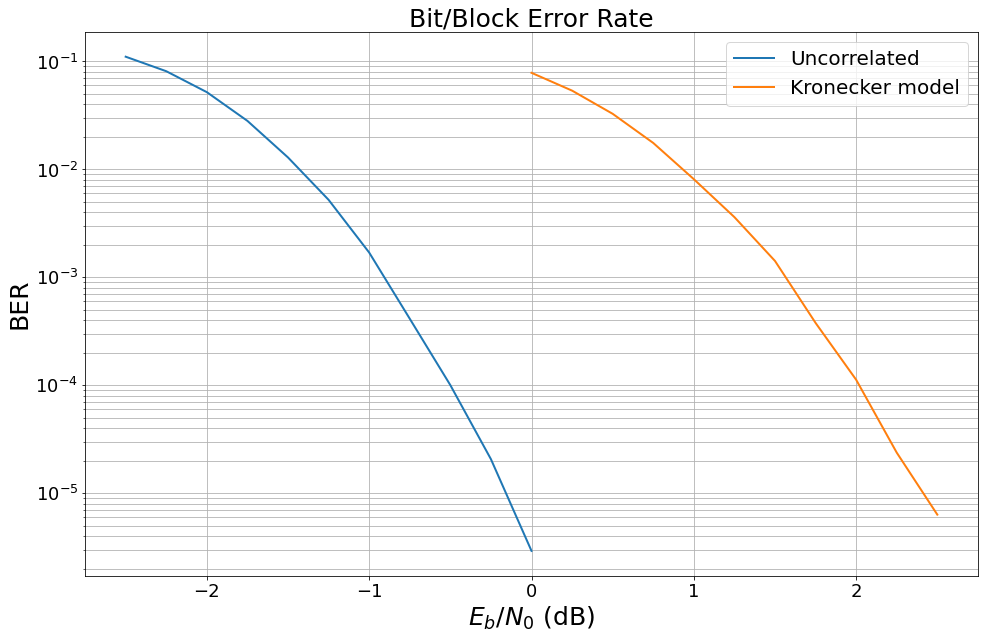

In [21]:
r_tx = exp_corr_mat(0.4, num_tx_ant) 
r_rx = exp_corr_mat(0.7, num_rx_ant)
model2 = Model(KroneckerModel(r_tx, r_rx))

ber_plot.simulate(model2,
        np.arange(0,2.6,0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=200,
        legend="Kronecker model");